In [1]:
!export HF_HOME=/run/media/anton/hdd/hf

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

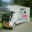

In [2]:
import os
import diffusers
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd.functional import jacobian

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from diffusers import DDPMPipeline, UNet2DModel

from urllib.request import urlopen 
import json 




os.environ['HF_HOME'] = "/run/media/anton/hdd/hf"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_id = "google/ddpm-cifar10-32"

ddpm = DDPMPipeline.from_pretrained(model_id) 
ddpm = ddpm.to(device)
image = ddpm().images[0]
image.save("ddpm_cifar10_generated.png")
image

In [3]:
random=False

if random:
    # create random unet
    unet_config_url = "https://huggingface.co/google/ddpm-cifar10-32/raw/main/config.json"
    response = urlopen(unet_config_url) 
    data_json = json.loads(response.read()) 
    unet_random = UNet2DModel(**data_json)
    
    # add to pipeline
    ddpm_random = DDPMPipeline(unet=unet_random, scheduler=ddpm.scheduler)
    ddpm = ddpm_random.to(device)

## Sample data

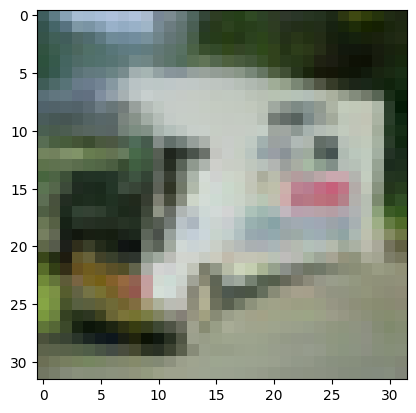

In [4]:
#cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
#training_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
#image, y = next(iter(training_data_loader))

#image = image.to(device)

from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype


def transform(image):
    transform = Compose([
        PILToTensor(),
        ConvertImageDtype(torch.float)
    ])
    return transform(image)

image = transform(image)

image = image[None, :]

# image = image[0]

plt.imshow(np.moveaxis(image[0].cpu().numpy(), 0, -1))

image = image.to(device)

plt.savefig("generated.jpg", dpi=300)

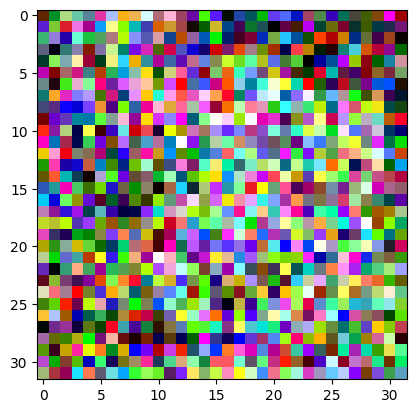

In [5]:
beta_start=1e-4
beta_end=2e-2
steps=1000
t=300

betas = torch.arange(start=beta_start, end=beta_end, step=(beta_end - beta_start)/steps)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, dim=0).to(device)

def add_noise(image, t, rescaled=False, return_beta=False):

    noise = torch.randn(image.shape).to(device)

    image_scaled = 2 * image - 1

    image_noisy = torch.sqrt(alphas_prod[t]) * image_scaled + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)

    if return_beta:
        return image_noisy, betas[t]
    
    return image_noisy


image_noisy = add_noise(image=image, t=t, rescaled=True)

plt.imshow(np.moveaxis(image_noisy[0].cpu().numpy(), 0, -1))

plt.savefig(f"generated_noisy_{t}.jpg", dpi=300)

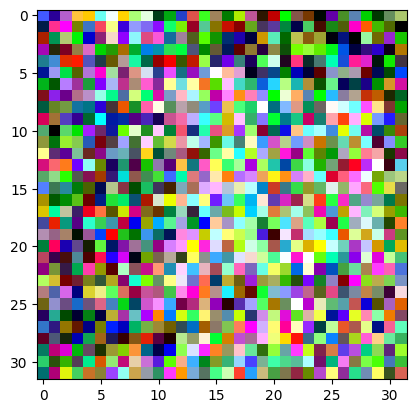

In [6]:
def denoise(image_noisy, t, rescaled=True):
    ## noisy image should be scaled [-1,1] 
    noise_pred = ddpm.unet(image_noisy, t).sample 
    #noise_pred = torch.clip(ddpm.unet(image_noisy, t).sample, -1, 1)

    mu_t = 1 / torch.sqrt(alphas[t]) * (image_noisy - (betas[t] / torch.sqrt(1 - alphas_prod[t])) * noise_pred)

    if rescaled: 
        return torch.clip(mu_t / 2 + 0.5, min=0, max=1)

    return mu_t

image_noisy = add_noise(image=image, t=t, rescaled=False)
image_denoised = denoise(image_noisy, t, rescaled=True)

plt.imshow(np.moveaxis(image_denoised[0].detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3523006..2.0488005].


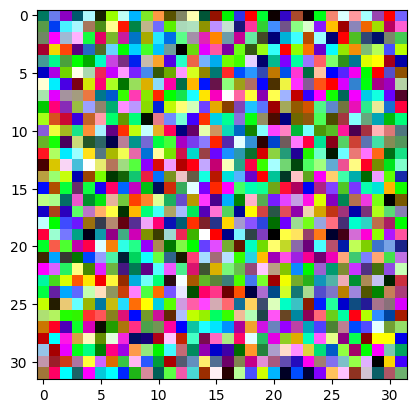

In [7]:
image_noisy = add_noise(image=image, t=t, rescaled=False)
noise_pred = ddpm.unet(image_noisy, t).sample / 2 + 0.5
plt.imshow(np.moveaxis(noise_pred[0].detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0093845..1.8333837].


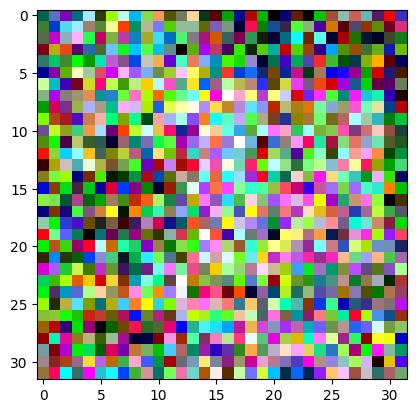

In [8]:
def noise_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    out = ddpm.unet(x, t).sample
    return torch.reshape(out, (3072,))

def denoise_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    pred = denoise(x, t, rescaled=False)
    return torch.reshape(pred, (3072,))

img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

img_denoised_v = denoise_as_vector(img_noisy_v)

plt.imshow(np.moveaxis(torch.reshape(img_denoised_v / 2 + 0.5, (1,3,32,32))[0].detach().cpu().numpy(), 0, -1))

In [9]:
from torch.autograd.functional import jacobian

J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)

In [10]:
# eig = torch.linalg.eig(J_trained)
J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)
svd = torch.svd(J_trained)

In [11]:
# plt.plot(sorted(eig.eigenvalues.detach().cpu().numpy(), reverse=True))

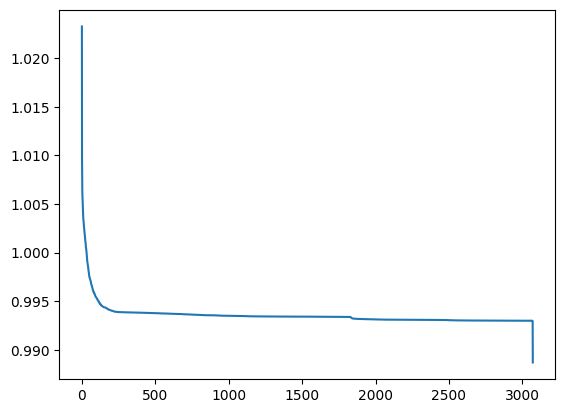

In [12]:
U = svd.U.detach().cpu().numpy()
S = svd.S.detach().cpu().numpy()
V = svd.V.detach().cpu().numpy()

plt.plot(S)

#U[0].shape

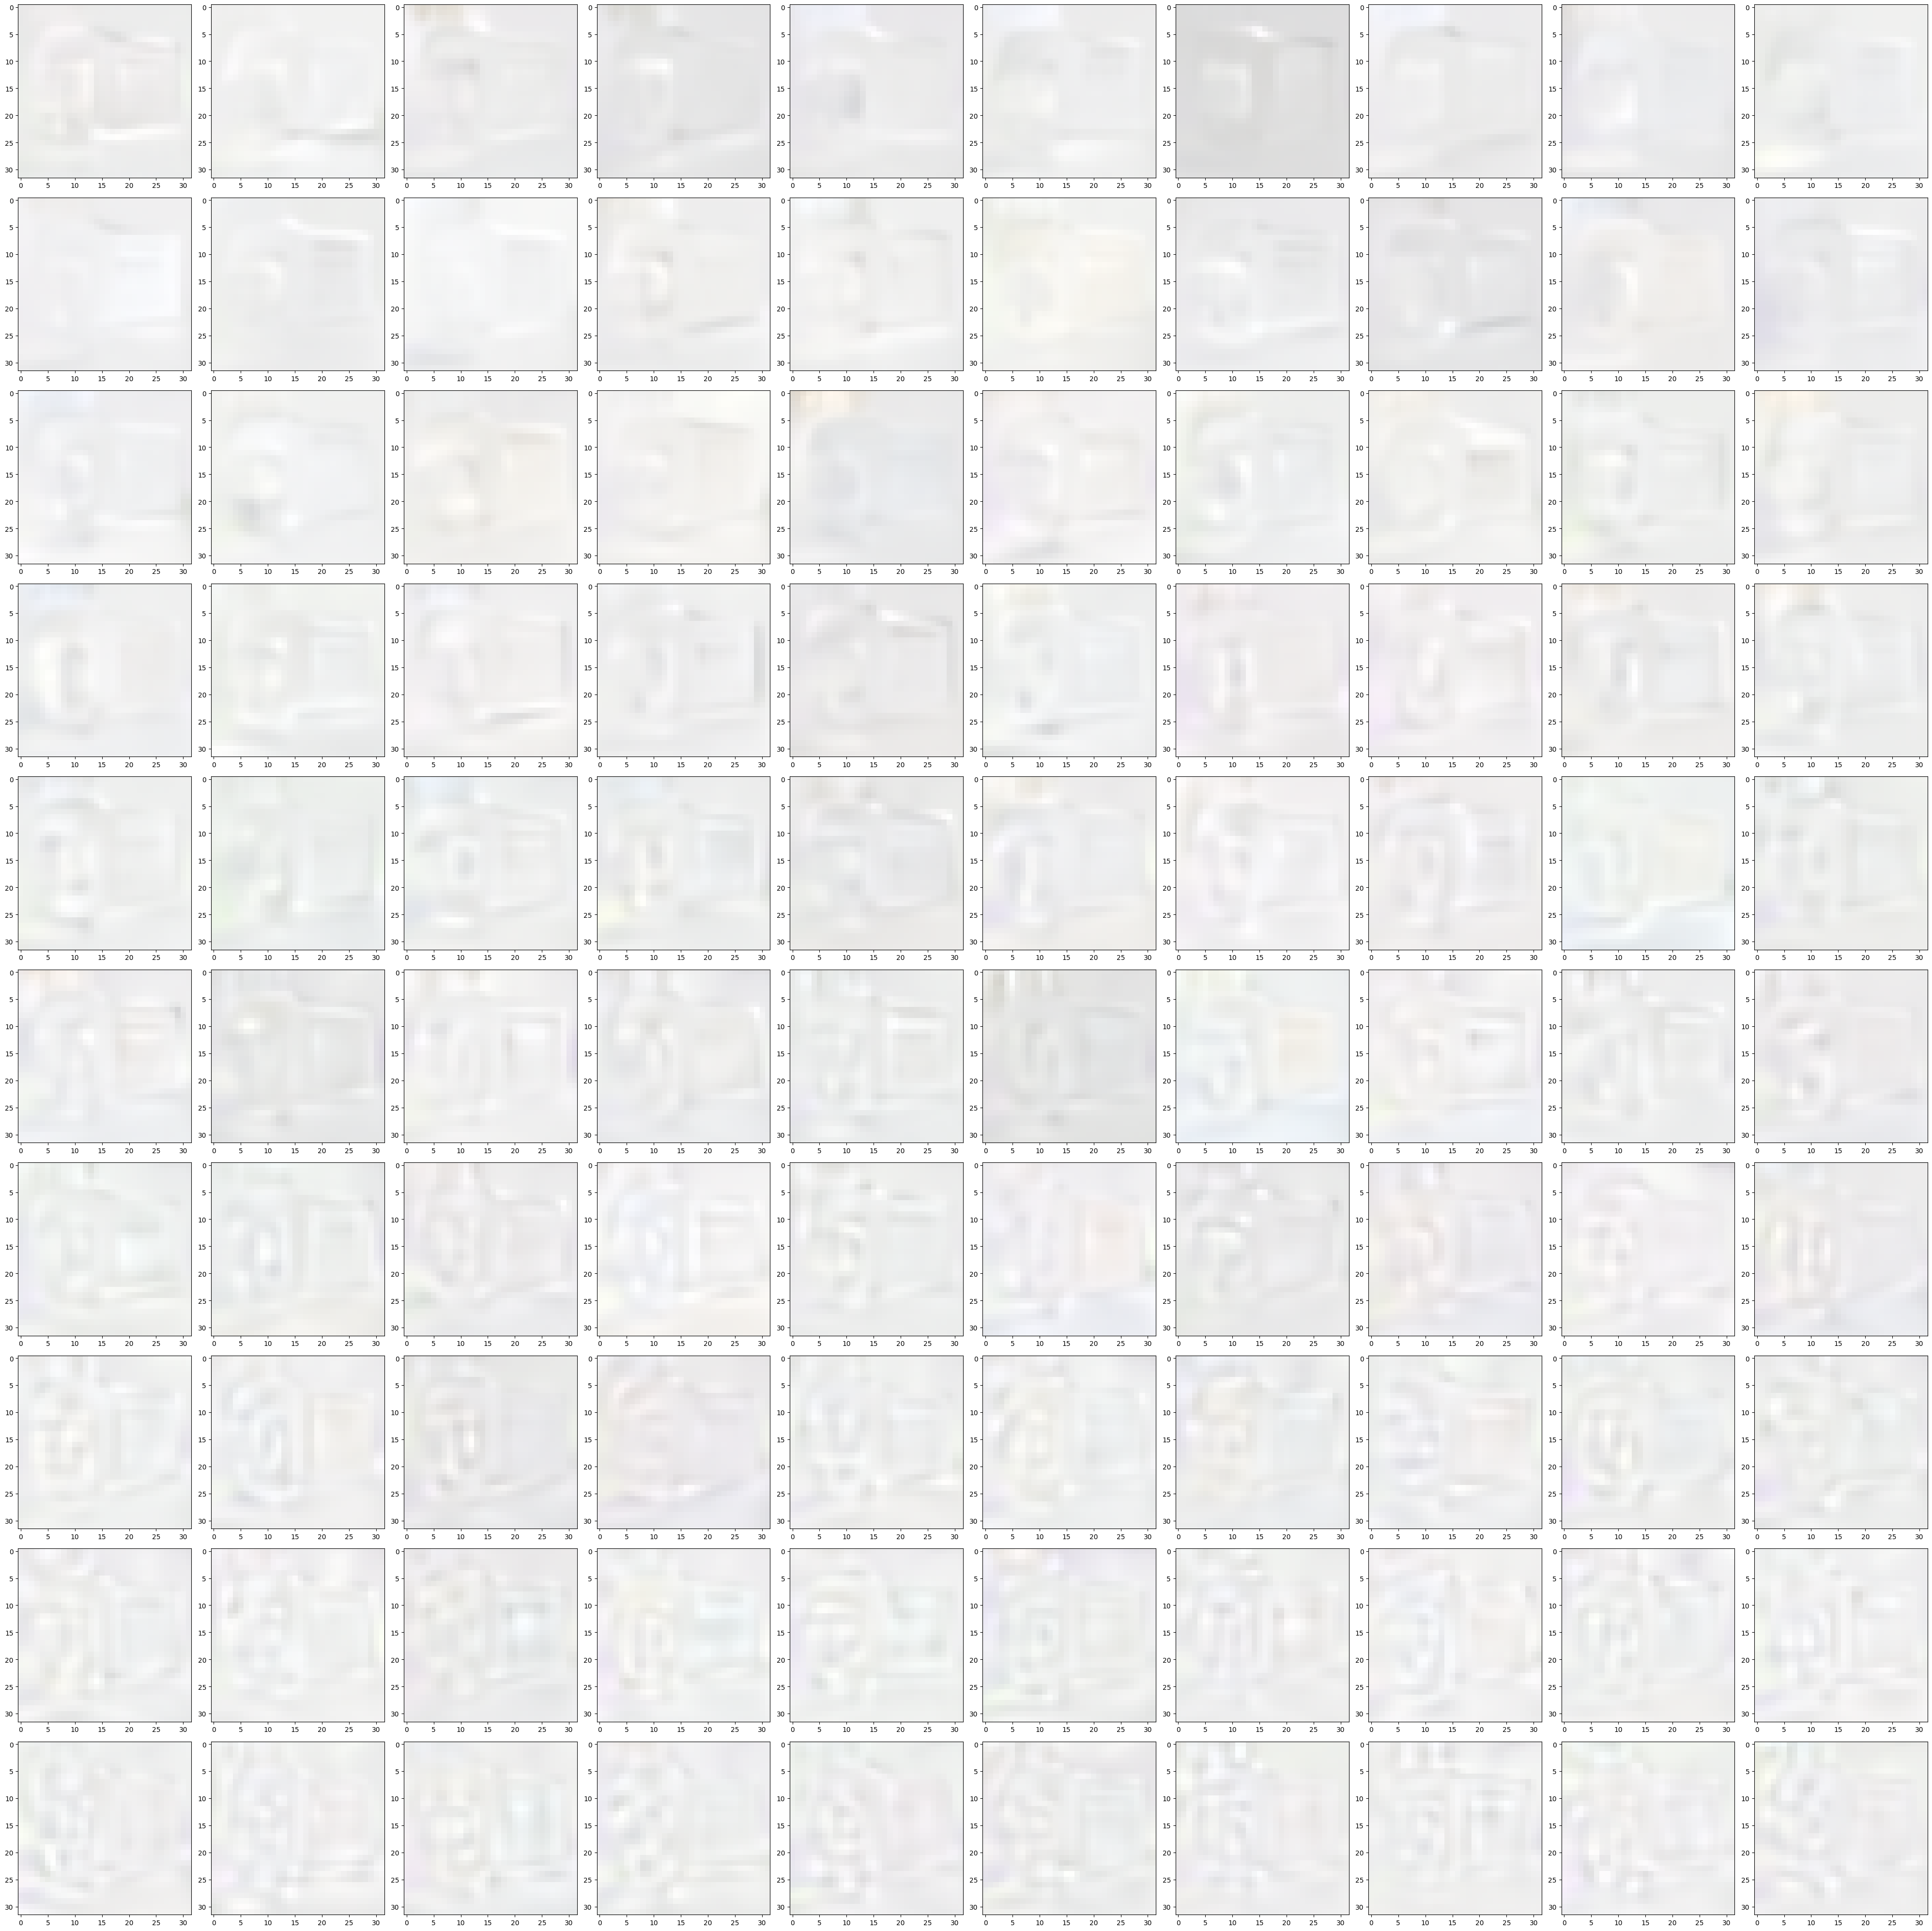

In [13]:
fig, axs = plt.subplots(10, 10, figsize=(40, 40))

axs = axs.flatten()

for j in range(100):
    top_sv = U[:, j]
    top_sv_tensor = torch.reshape(torch.tensor(top_sv), (3, 32, 32)) / 2 + 0.5
    top_sv_tensor /= torch.max(torch.abs(top_sv_tensor))
    axs[j].imshow(np.moveaxis(top_sv_tensor.numpy(), 0, -1))

plt.tight_layout()
plt.savefig(f"denoiser_top_sv_{t}.jpg",dpi=400)

In [14]:
torch.norm(J_trained - torch.diag(torch.diagonal(J_trained, 0)), p="fro")

tensor(0.0749, device='cuda:0')

In [15]:
torch.norm(svd.U @ svd.V.t(), p="fro")

tensor(55.4485, device='cuda:0')

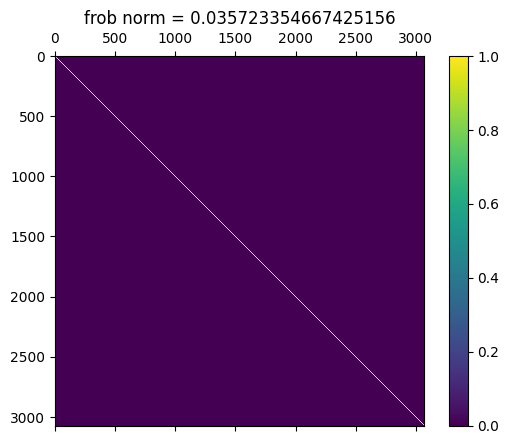

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(svd.U.cpu() @ svd.V.t().cpu(), interpolation='nearest')
fig.colorbar(cax)

ax.set_title("frob norm = " + str(torch.norm(svd.U @ svd.V.t() - torch.eye(3072).to(device), p="fro").item()))
plt.savefig(f"denoiser_diag_{t}.jpg",dpi=400)

In [17]:
torch.norm(svd.U @ svd.V.t() - torch.eye(3072).to(device), p="fro")

tensor(0.0357, device='cuda:0')

## Project noisy image onto singular vectors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.017786..1.841411].


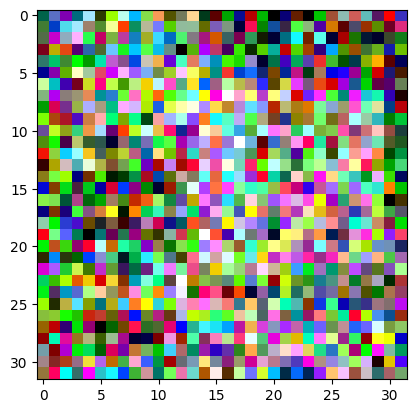

In [18]:
plt.imshow(np.moveaxis((image_noisy[0] / 2 + 0.5).cpu().numpy(), 0, -1))

In [19]:
idx = torch.arange(10)

print(svd.V.t()[idx].shape)

print(torch.diag(svd.S)[:, idx].shape)

torch.Size([10, 3072])
torch.Size([3072, 10])


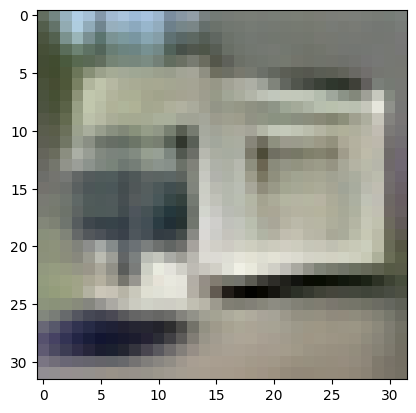

In [23]:
N_PROJ = 20

def svd_projection(svd, v, idx=None):

    n_sv = len(svd.S)
    
    if idx is None:
        idx = torch.arange(n_sv)
        
    return svd.U @ (torch.diag(svd.S + 0.5*torch.randn(n_sv).to(device))[:, idx] @ (svd.V.t()[idx] @ v))

img_noisy_projected = torch.reshape(svd_projection(svd, img_noisy_v, idx=torch.arange(N_PROJ)), (1,3,32,32))

img_noisy_projected = img_noisy_projected / torch.max(torch.abs(img_noisy_projected))

img_noisy_projected = torch.clip(img_noisy_projected / 2 + 0.5, min=0, max=1)

plt.imshow(np.moveaxis(img_noisy_projected[0].cpu().numpy(), 0, -1))

In [44]:
def noise_top_sv(svd, v, idx=None, sigma=0):

    n_sv = len(svd.S)
    
    if idx is None:
        idx = torch.arange(n_sv)

    noisy_S = svd.S + sigma*torch.randn(n_sv).to(device)

    print(noisy_S.shape)

    noisy_proj = svd.U @ (torch.diag(noisy_S)[:, idx] @ (svd.V.t()[idx] @ v))

    idx_comp = torch.ones(n_sv, dtype=bool)
    idx_comp[idx] = False

    comp_proj = svd.U @ (torch.diag(svd.S)[:, idx_comp] @ (svd.V.t()[idx_comp] @ v))
        
    return noisy_proj + comp_proj

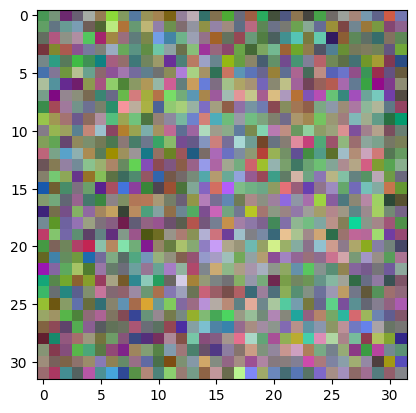

In [28]:
img_noisy_projected = torch.reshape(noise_top_sv(svd, img_noisy_v, idx=torch.arange(N_PROJ), sigma=0.5), (1,3,32,32))

img_noisy_projected = img_noisy_projected / torch.max(torch.abs(img_noisy_projected))

img_noisy_projected = torch.clip(img_noisy_projected / 2 + 0.5, min=0, max=1)

plt.imshow(np.moveaxis(img_noisy_projected[0].cpu().numpy(), 0, -1))

## Messing with projections

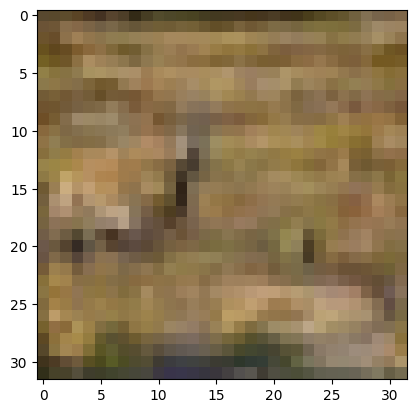

In [86]:
def show_image(image, rescale=True, flat=False):
    if flat:
        image = torch.reshape(image, (1,3,32,32))
    if type(image) == torch.tensor:
        image = (image[0] / 2 + 0.5).detach().cpu().numpy()
    if len(image.shape) == 4:
        image = image[0]
    if rescale:
        image = image / 2 + 0.5
        
    plt.imshow(np.moveaxis(image.detach().cpu().numpy(), 0, -1))

def get_noise():
    return torch.randn((1,3,32,32)).to(device)

def generate():

    x_prev = torch.clip(get_noise(), -1, 1)
    
    ddpm.unet.eval()
    
    for t in reversed(range(1000)):
        
        if t > 0:
            z = get_noise()
        else:
            z = torch.zeros((1, 3,32,32)).to(device)
    
        with torch.no_grad():
            eps = ddpm.unet(x_prev, t).sample 
    
        eps_coeff = (betas[t]) / torch.sqrt(1 - alphas_prod[t]) 
    
        mu = (1 / torch.sqrt(alphas[t])) * (x_prev - eps_coeff * eps)
    
        #mu = torch.clip(mu, -1, 1)
    
        # x_new = torch.clip(mu + torch.sqrt(betas[t]) * z, -1, 1)
        x_new = mu + torch.sqrt(betas[t]) * z
        
        x_prev = x_new

    return x_new

def generate_from(x, T):
    
    x_prev = x
    
    ddpm.unet.eval()
    
    for t in reversed(range(0, T)):
        
        if t > 0:
            z = get_noise()
        else:
            z = torch.zeros((1, 3,32,32)).to(device)
    
        with torch.no_grad():
            eps = ddpm.unet(x_prev, t).sample 
    
        eps_coeff = (betas[t]) / torch.sqrt(1 - alphas_prod[t]) 
    
        mu = (1 / torch.sqrt(alphas[t])) * (x_prev - eps_coeff * eps)
    
        #mu = torch.clip(mu, -1, 1)
    
        # x_new = torch.clip(mu + torch.sqrt(betas[t]) * z, -1, 1)
        x_new = mu + torch.sqrt(betas[t]) * z
        
        x_prev = x_new

    return x_new

def add_noise(image, t, rescaled=False):

    noise = torch.randn(image.shape).to(device)

    image_noisy = torch.sqrt(alphas_prod[t]) * image + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)
    
    return image_noisy

x_new = generate()
show_image(x_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27790123..1.1394564].


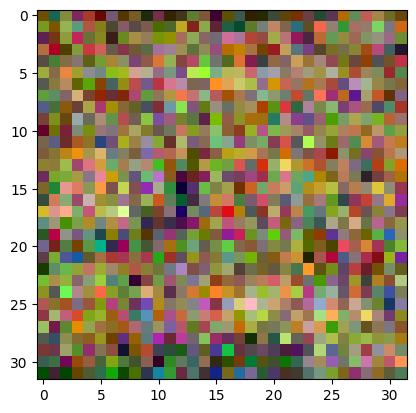

In [87]:
x_noisy = add_noise(x_new, 100)
show_image(x_noisy)

In [88]:
t = 100

x_noisy = add_noise(x_new, t)
x_noisy_v = torch.reshape(x_noisy, (3072,))


J_trained = jacobian(denoise_as_vector, inputs=x_noisy_v)
svd = torch.svd(J_trained)

In [90]:
def generate_from(x, T):
    
    x_prev = x
    
    ddpm.unet.eval()
    
    for t in reversed(range(0, T)):
        
        if t > 0:
            z = get_noise()
        else:
            z = torch.zeros((1, 3,32,32)).to(device)
    
        with torch.no_grad():
            eps = ddpm.unet(x_prev, t).sample 
    
        eps_coeff = (betas[t]) / torch.sqrt(1 - alphas_prod[t]) 
    
        mu = (1 / torch.sqrt(alphas[t])) * (x_prev - eps_coeff * eps)
    
        #mu = torch.clip(mu, -1, 1)
    
        # x_new = torch.clip(mu + torch.sqrt(betas[t]) * z, -1, 1)
        x_new = mu + torch.sqrt(betas[t]) * z
        
        x_prev = x_new

    return x_new

def add_noise(image, t, rescaled=False):

    noise = torch.randn(image.shape).to(device)

    image_noisy = torch.sqrt(alphas_prod[t]) * image + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)
    
    return image_noisy

def noise_top_sv(svd, v, idx=None, sigma=0):

    n_sv = len(svd.S)
    
    if idx is None:
        idx = torch.arange(n_sv)

    noisy_S = svd.S + sigma*torch.randn(n_sv).to(device)

    noisy_proj = svd.U @ (torch.diag(noisy_S)[:, idx] @ (svd.V.t()[idx] @ v))

    idx_comp = torch.ones(n_sv, dtype=bool)
    idx_comp[idx] = False

    comp_proj = svd.U @ (torch.diag(svd.S)[:, idx_comp] @ (svd.V.t()[idx_comp] @ v))
        
    return noisy_proj + comp_proj

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51358545..1.1947036].


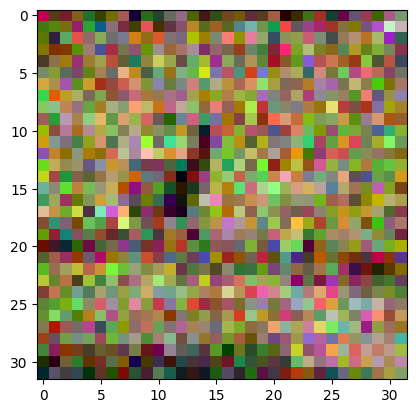

In [91]:
x_noisy_v = torch.reshape(x_noisy, (3072,))
x_proj_noise = noise_top_sv(svd, x_noisy_v, idx=torch.arange(50), sigma=0.5)
show_image(x_proj_noise, flat=True)


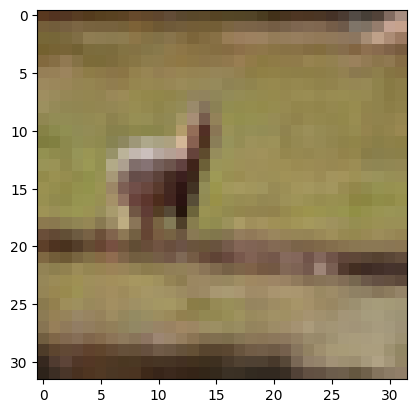

In [92]:
x_proj_noise = torch.reshape(x_proj_noise, (1,3,32,32))

x_new_dn = generate_from(x_proj_noise, T=t)

show_image(x_new_dn)

Text(0.5, 0.98, 'generated by perturbing top 50 s.v. with $N(0, 0.02^2)$')

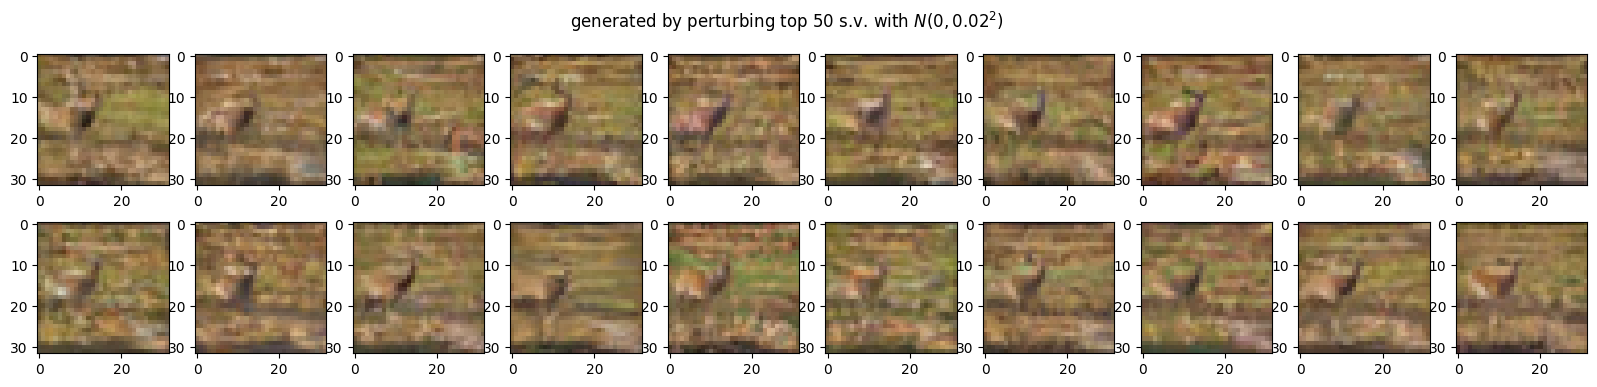

In [112]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

axs = axs.flatten()

for j in range(20):

    x_proj_noise = noise_top_sv(svd, x_noisy_v, idx=torch.arange(50), sigma=0.02)

    x_proj_noise = torch.reshape(x_proj_noise, (1,3,32,32))

    x_new_dn = generate_from(x_proj_noise, T=t)
    
    axs[j].imshow(np.moveaxis((x_new_dn[0].detach() / 2 + 0.5).cpu().numpy(), 0, -1))

fig.suptitle("generated by perturbing top 50 s.v. with $N(0, 0.02^2)$")

Text(0.5, 0.98, 'generated by reintroducing noise')

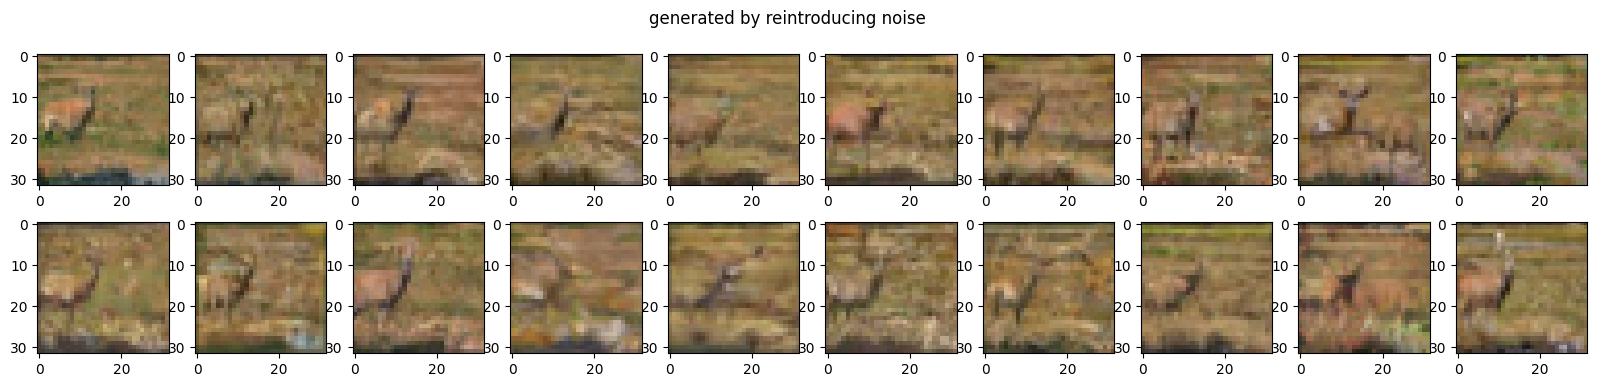

In [113]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

axs = axs.flatten()

for j in range(20):

    x_n = add_noise(x_new, t)

    x_new_dn = generate_from(x_n, T=t)
    
    axs[j].imshow(np.moveaxis((x_new_dn[0].detach() / 2 + 0.5).cpu().numpy(), 0, -1))

fig.suptitle("generated by reintroducing noise")

## Comparison with data

Train image similarity with dataset

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


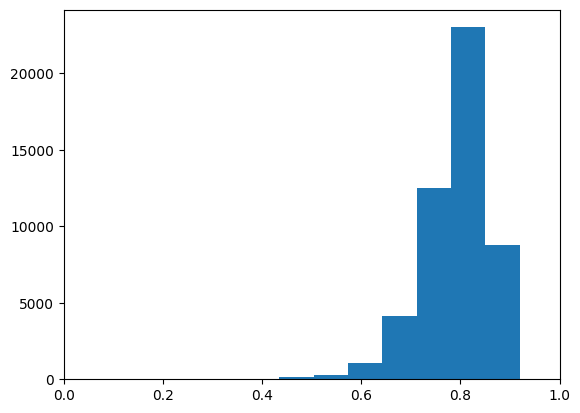

In [158]:
from datasets import load_dataset
from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype

cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
cifar10_iterator = iter(cifar10)

def transform(image):
    transform = Compose([
        PILToTensor(),
        ConvertImageDtype(torch.float)
    ])
    return transform(image)

similarity = []

# img_generated = transform(image)
img_generated = image

for i, data in enumerate(cifar10):
    img_test = transform(data["img"]).to(device)
    
    m = torch.sum(
        (img_generated / torch.norm(img_generated)) * 
        (img_test / torch.norm(img_test))
    )
    # m = torch.norm(img_test - img_generated)
    
    similarity.append(m.detach().cpu())

    print(i) if i%1000==0 else None
    
plt.hist(similarity)
plt.xlim((0,1))

plt.savefig("cosine with CIFAR10 train")

similarity = np.array(similarity)

In [159]:
similarity_indexed = np.stack((np.arange(50000), similarity))
similarity_indexed_sorted = similarity_indexed[:, similarity_indexed[1].argsort()]

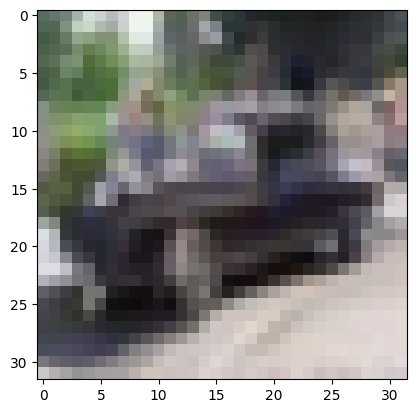

In [160]:
plt.imshow(np.moveaxis(image[0].cpu().numpy(), 0, -1))

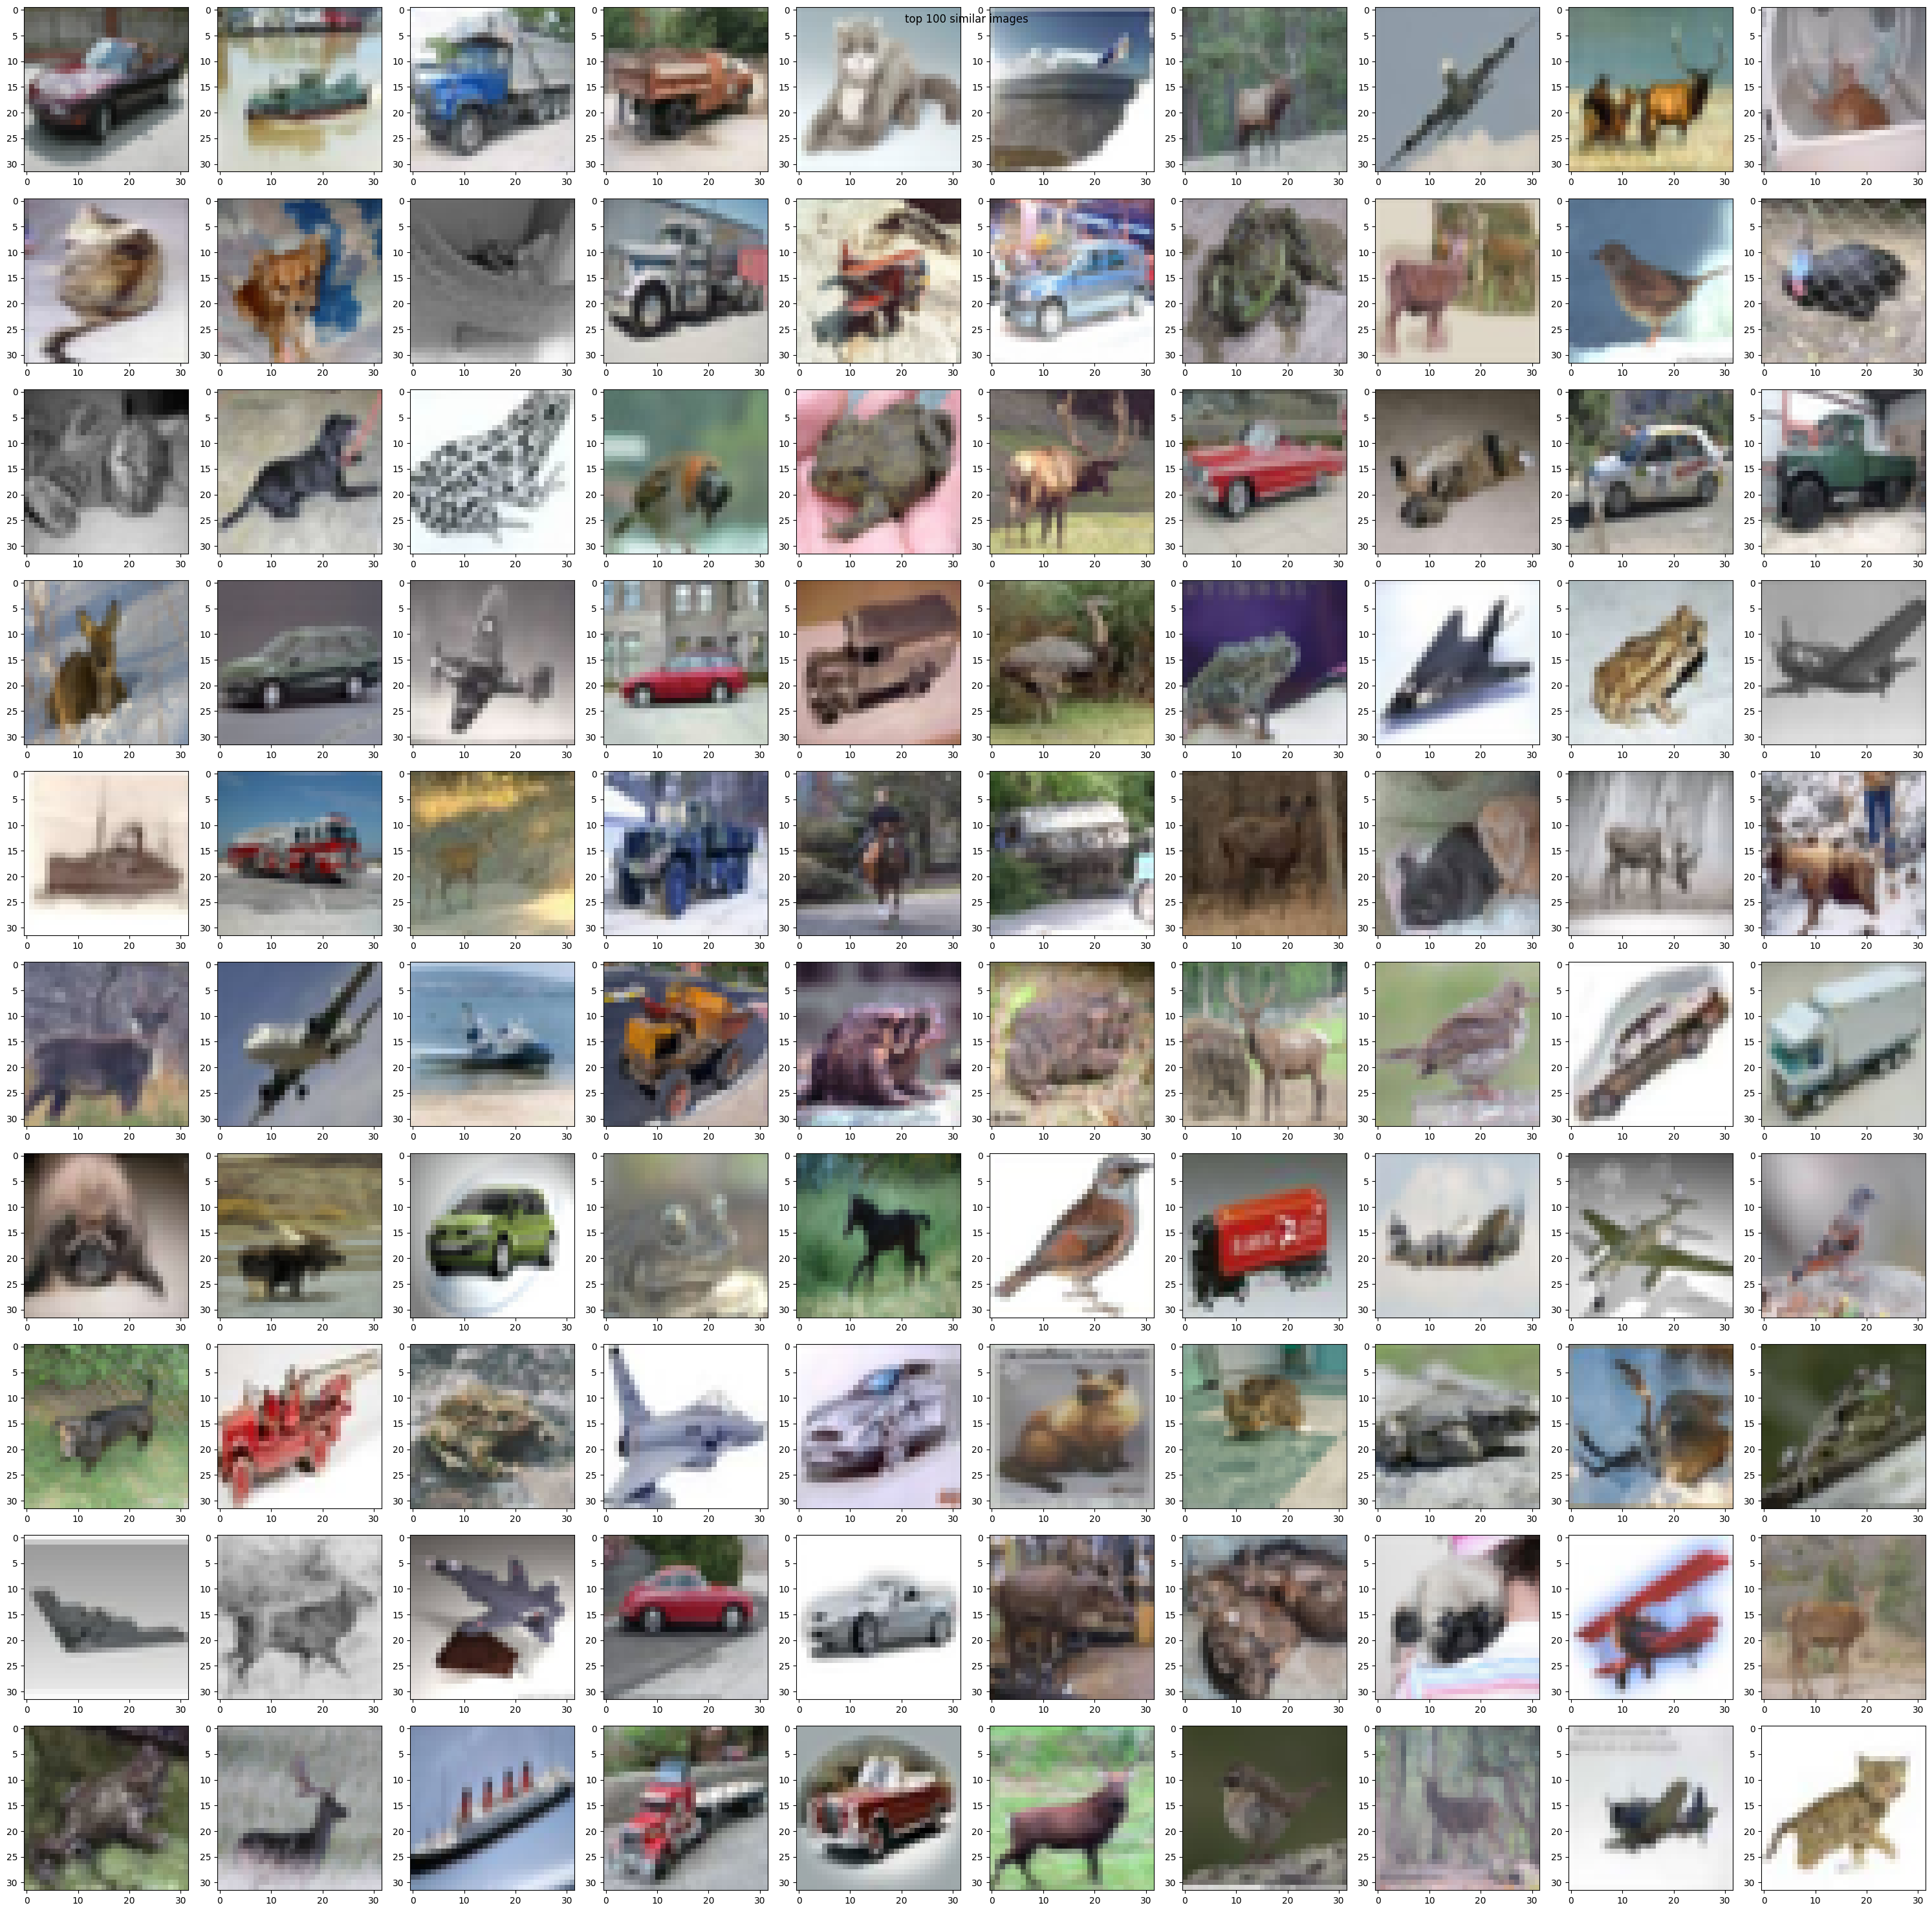

In [161]:
n = 1000
top_n_idx = similarity_indexed_sorted[0, -n:]
top_n_idx = top_n_idx[::-1]
top_n_img = {}

for i, data in enumerate(cifar10): 
    if i in top_n_idx:
        top_n_img[i] = data["img"]


fig, axs = plt.subplots(10, 10, figsize=(30, 30))

axs = axs.flatten()

for j in range(100):
    axs[j].imshow(np.moveaxis(transform(top_n_img[top_n_idx[j]]).numpy(), 0, -1))

fig.suptitle("top 100 similar images")

plt.tight_layout()

plt.savefig("generated_CIFAR10_train_top100.jpg", dpi=400)

In [162]:
n_decomp = 100

top_decomp = [top_n_img[j] for j in top_n_idx[:n_decomp]]

M_top = torch.stack([torch.flatten(transform(img)) * 2 - 1 for img in top_decomp])
svd_top = torch.svd(M_top)
# pca_top = torch.pca_lowrank(M_top, center=True)


# pca_top[2].shape
svd_top.V.t().shape

torch.Size([100, 3072])

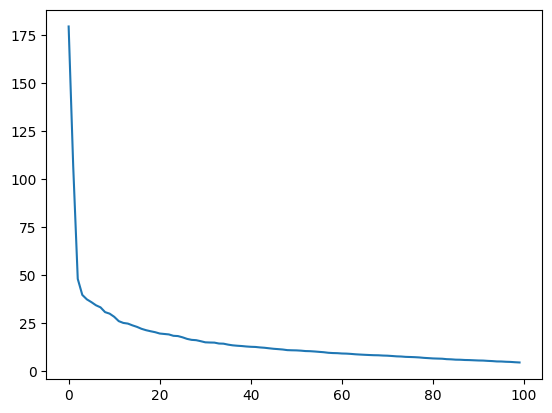

In [163]:
plt.plot(svd_top.S.numpy())

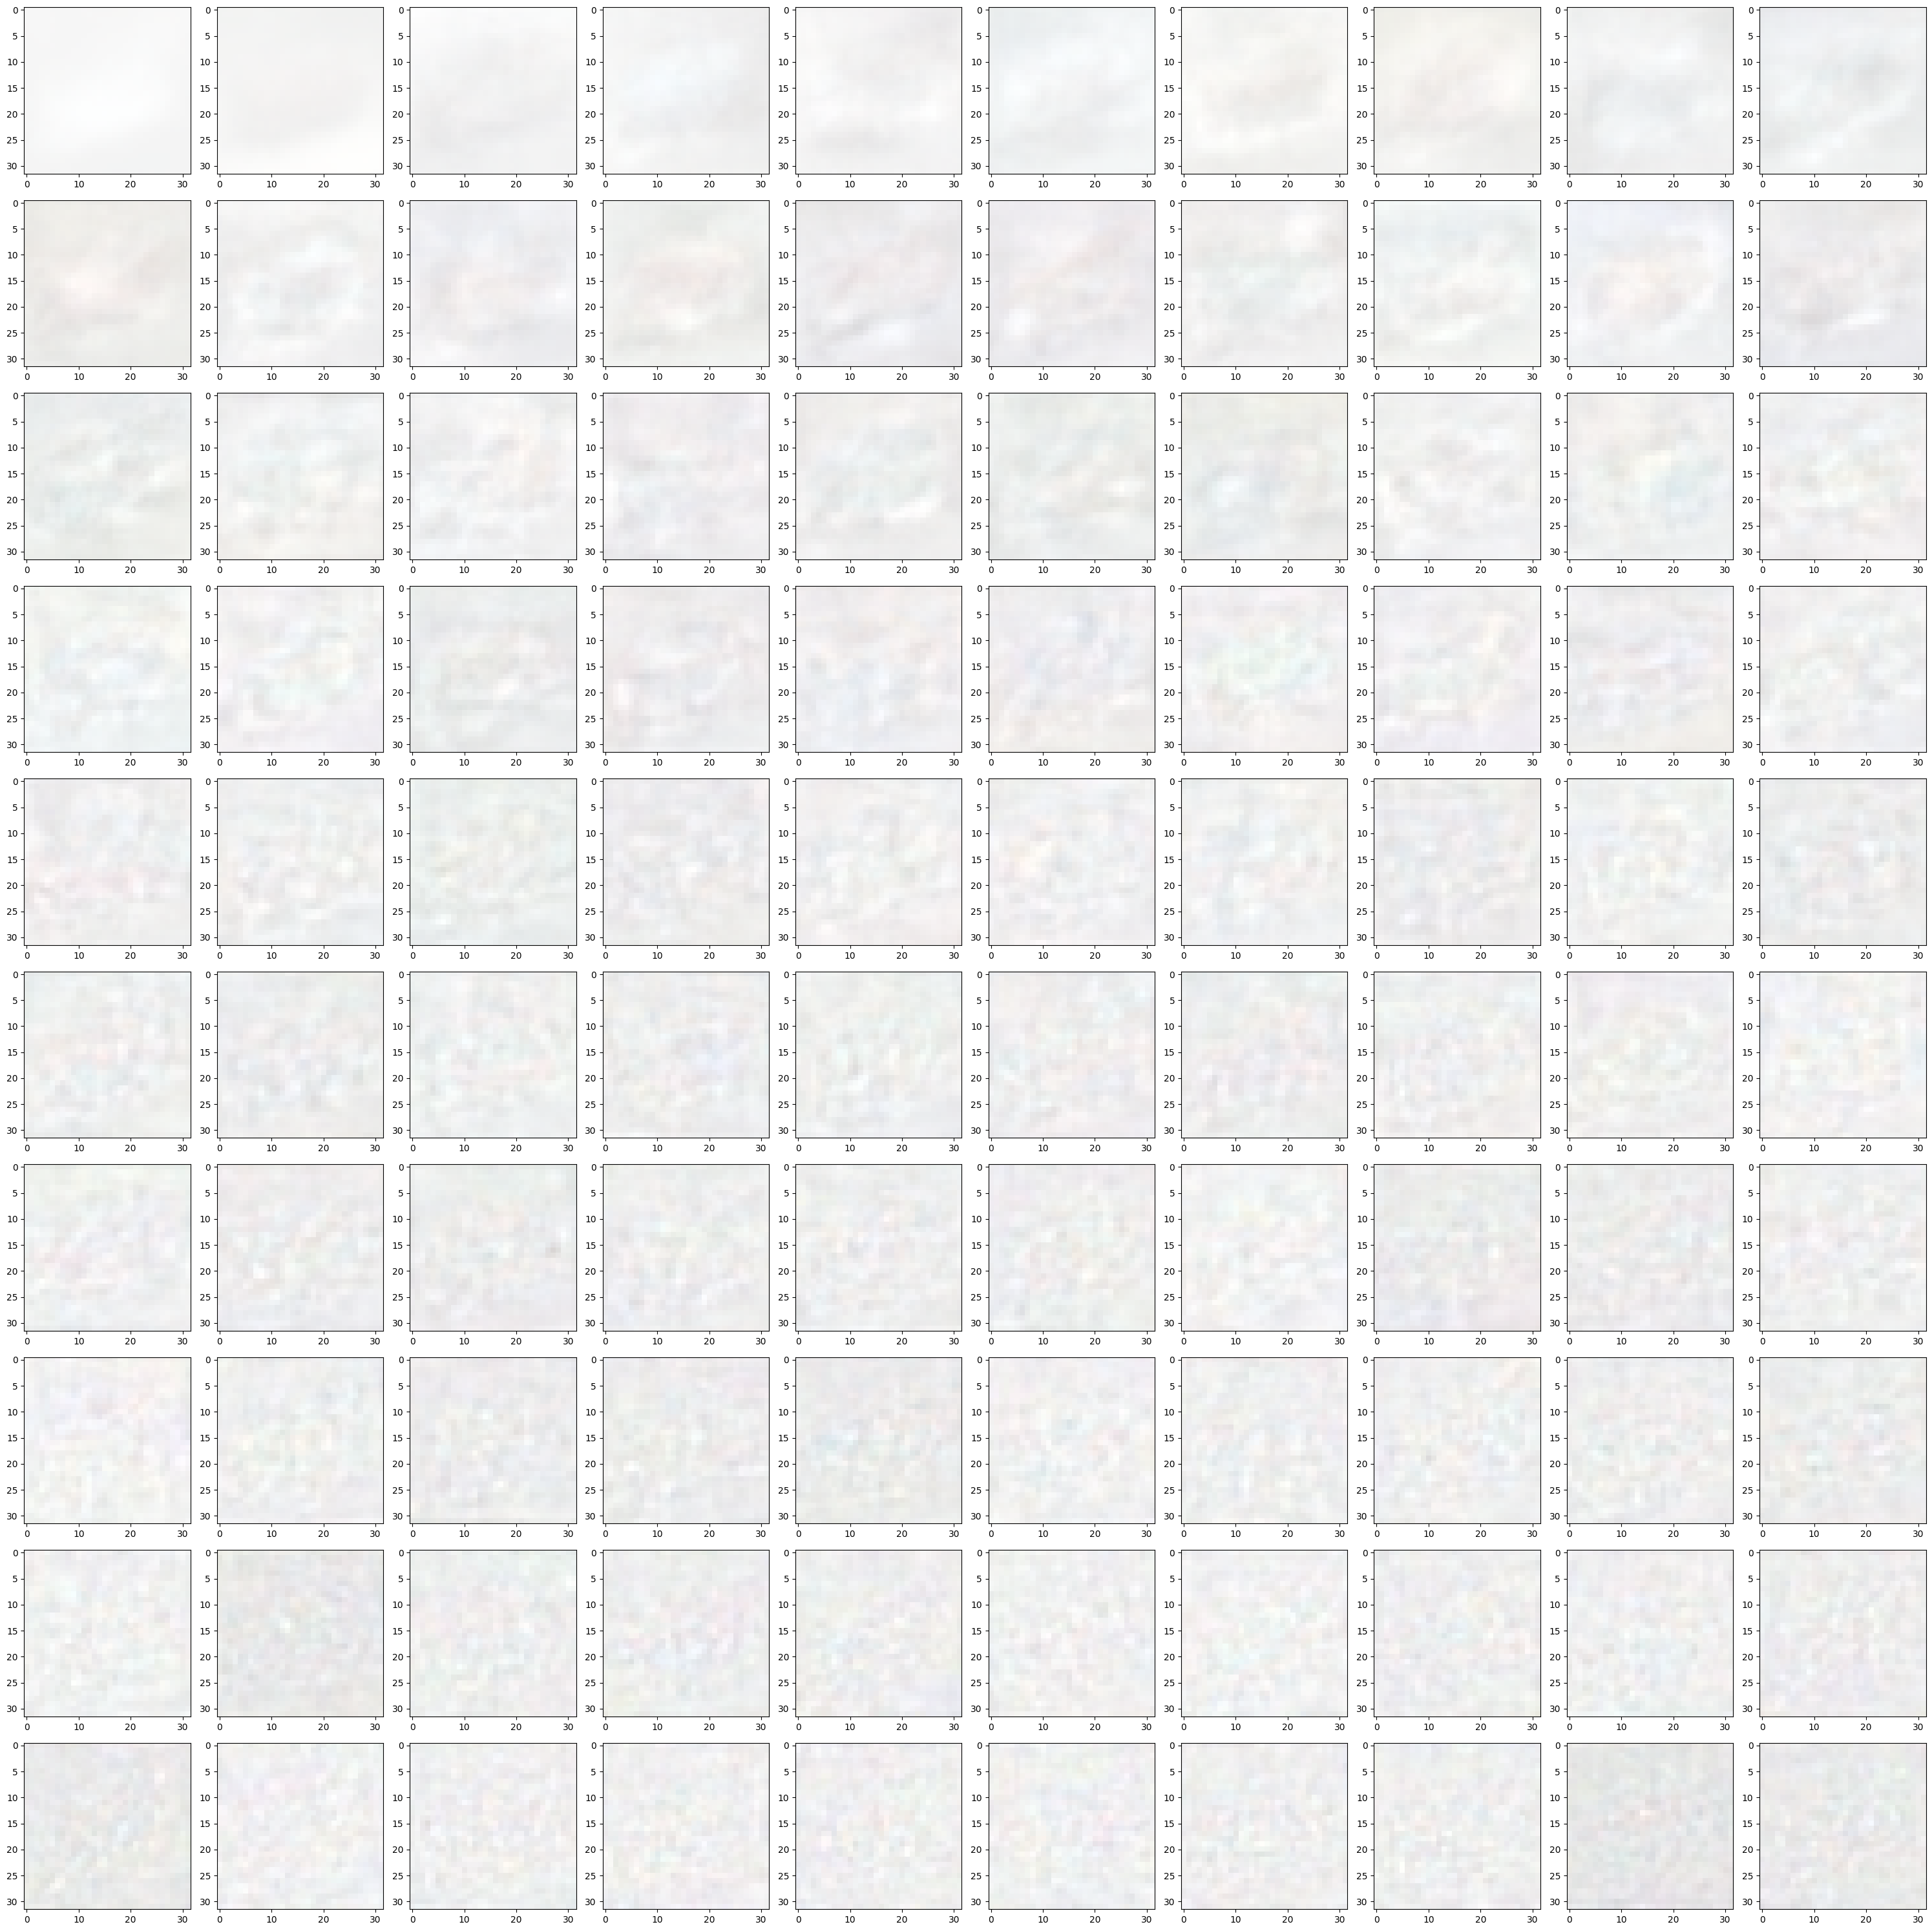

In [164]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

n_top_sv = n_decomp

axs = axs.flatten()

for j in range(n_top_sv):
    sv_reshaped = svd_top.V.t()[j].reshape((3,32,32)) / 2 + 0.5
    # sv_reshaped = pca_top[2].t()[j].reshape((3,32,32)) / 2 + 0.5

    sv_reshaped /= torch.max(torch.abs(sv_reshaped))

    axs[j].imshow(
        np.moveaxis(sv_reshaped.numpy(), 0, -1)
    )

plt.tight_layout()
plt.savefig(f"closest_{n_decomp}_data.jpg", dpi=400)


In [165]:
svd_top.V.t().shape
torch.norm(svd_top.V.t(), dim=1)[None, :]

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])

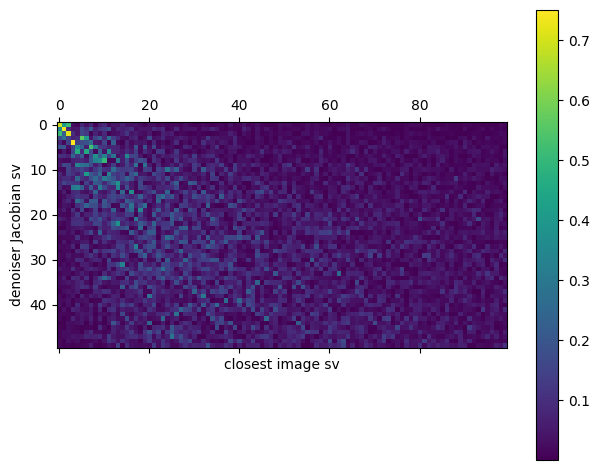

In [166]:
cos_sv = torch.abs(svd.V.t()[:50] @ svd_top.V.to(device))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cos_sv.cpu(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xlabel("closest image sv")
ax.set_ylabel("denoiser Jacobian sv")

plt.tight_layout()
plt.savefig(f"cos_Jac_data_t={t}.jpg", dpi=300)

## TODO: 
- cosine similarity of this svd with singular vectors of denoiser jacobian
- denoiser jacobian sv similarity to training images
- sv of closest data can be written as some of denoiser sv? i.e. project the singular vectors
- in general, how can we compare the two sets of singular vectors?
- in a model that completely memorizes: what do the singular vectors do?